In [1]:
!pip install optuna

In [2]:
import shap
import optuna
from sklearn import set_config
from xgboost import XGBRegressor
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split
from sklearn.metrics import root_mean_squared_error
from sklearn.metrics import r2_score

# Dataset

In [3]:
set_config(transform_output="pandas")

In [4]:
# load the data

data = fetch_california_housing(as_frame=True)

In [5]:
data.keys()

dict_keys(['data', 'target', 'frame', 'target_names', 'feature_names', 'DESCR'])

In [6]:
# make X and y

X, y = data.data, data.target

In [7]:
# columns names

feature_names = data.feature_names

feature_names

['MedInc',
 'HouseAge',
 'AveRooms',
 'AveBedrms',
 'Population',
 'AveOccup',
 'Latitude',
 'Longitude']

In [8]:
X.head()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24
3,5.6431,52.0,5.817352,1.073059,558.0,2.547945,37.85,-122.25
4,3.8462,52.0,6.281853,1.081081,565.0,2.181467,37.85,-122.25


In [9]:
y.head()

,MedHouseVal
0,4.526
1,3.585
2,3.521
3,3.413
4,3.422


In [10]:
X.shape

(20640, 8)

In [11]:
# split the data

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print("Shape of Training data: ", X_train.shape)
print("Shape of Testing data: ", X_test.shape)

Shape of Training data:  (16512, 8)
Shape of Testing data:  (4128, 8)


# Model

In [12]:
# model
xgb_model = XGBRegressor(objective='reg:squarederror', random_state=42,
                         n_jobs=-1, learning_rate=0.2, n_estimators=200,
                         reg_lambda=50, max_depth=7, gamma=0.05)

In [13]:
# fit the training data
xgb_model.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             feature_weights=None, gamma=0.05, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.2, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=7,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=200,
             n_jobs=-1, num_parallel_tree=None, ...)

In [14]:
# claculate the predictions
y_pred_train = xgb_model.predict(X_train)
y_pred_test = xgb_model.predict(X_test)

# calculate the RMSE and R2 score
rmse_train = root_mean_squared_error(y_train, y_pred_train)
rmse_test = root_mean_squared_error(y_test, y_pred_test)

r2_train = r2_score(y_train, y_pred_train)
r2_test = r2_score(y_test, y_pred_test)

print(f"Train RMSE: {rmse_train:.4f}, R2: {r2_train:.4f}")
print(f"Test RMSE: {rmse_test:.4f}, R2: {r2_test:.4f}")

Train RMSE: 0.2899, R2: 0.9371
Test RMSE: 0.4474, R2: 0.8472


# HP Tuning

In [15]:
# tune the model

def objective(trial):
    params = {
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
        'n_estimators': trial.suggest_int('n_estimators', 50, 500),
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'reg_lambda': trial.suggest_float('reg_lambda', 1, 100),
        'gamma': trial.suggest_float('gamma', 0, 2),
        "subsample": trial.suggest_float('subsample', 0.7, 1.0),
        "n_jobs": -1,
        'objective': 'reg:squarederror',
        'random_state': 42
    }

    # set the model with the parameters
    model = XGBRegressor()

    model.set_params(**params)

    # fit the model
    model.fit(X_train, y_train)

    # predict the test data
    y_pred = model.predict(X_test)
    r2 = r2_score(y_test, y_pred)
    return r2

In [16]:
# create a study
study = optuna.create_study(direction='maximize')

study.optimize(func=objective, n_trials=50, show_progress_bar=True, n_jobs=-1)

[I 2026-02-06 12:25:17,338] A new study created in memory with name: no-name-41fa01bc-d1a9-409f-a4bf-ac6249a3476e


  0%|          | 0/50 [00:00<?, ?it/s]

[I 2026-02-06 12:25:18,337] Trial 1 finished with value: 0.8164265919623832 and parameters: {'learning_rate': 0.07638890033977572, 'n_estimators': 133, 'max_depth': 9, 'reg_lambda': 72.56701867829378, 'gamma': 1.8939676198829651, 'subsample': 0.7879992608268748}. Best is trial 1 with value: 0.8164265919623832.
[I 2026-02-06 12:25:18,686] Trial 0 finished with value: 0.8422357492850502 and parameters: {'learning_rate': 0.1741264376045652, 'n_estimators': 186, 'max_depth': 6, 'reg_lambda': 81.87873371144615, 'gamma': 0.40233007105236585, 'subsample': 0.7732843152121152}. Best is trial 0 with value: 0.8422357492850502.
[I 2026-02-06 12:25:19,554] Trial 2 finished with value: 0.8297995912682947 and parameters: {'learning_rate': 0.16094902664375954, 'n_estimators': 386, 'max_depth': 9, 'reg_lambda': 64.32178273560747, 'gamma': 1.070200669796486, 'subsample': 0.8516840602287153}. Best is trial 0 with value: 0.8422357492850502.
[I 2026-02-06 12:25:19,596] Trial 3 finished with value: 0.819275

In [17]:
# get the best parameters
study.best_params

{'learning_rate': 0.16521157065465328,
 'n_estimators': 296,
 'max_depth': 9,
 'reg_lambda': 77.31388603089941,
 'gamma': 0.11337711668082469,
 'subsample': 0.7870680337735766}

In [18]:
# get the best value
study.best_value

0.8499596927456625

In [19]:
# get the best estimator
best_model = XGBRegressor(**study.best_params)

best_model.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             feature_weights=None, gamma=0.11337711668082469, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.16521157065465328, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=9, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=296, n_jobs=None,
             num_parallel_tree=None, ...)

In [20]:
# print the metrics
y_pred_train = best_model.predict(X_train)
y_pred_test = best_model.predict(X_test)

rmse_train = root_mean_squared_error(y_train, y_pred_train)
rmse_test = root_mean_squared_error(y_test, y_pred_test)

r2_train = r2_score(y_train, y_pred_train)
r2_test = r2_score(y_test, y_pred_test)

print(f"Train RMSE: {rmse_train:.4f}, R2: {r2_train:.4f}")
print(f"Test RMSE: {rmse_test:.4f}, R2: {r2_test:.4f}")

Train RMSE: 0.2407, R2: 0.9567
Test RMSE: 0.4406, R2: 0.8519


# SHAP

In [21]:
best_model

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             feature_weights=None, gamma=0.11337711668082469, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.16521157065465328, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=9, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=296, n_jobs=None,
             num_parallel_tree=None, ...)

In [22]:
# create the tree explainer

explainer = shap.TreeExplainer(model=best_model,
                               data=X_train)

In [23]:
# expected value
explainer.expected_value

np.float64(1.9987080014120813)

In [24]:
# calculate the shap values for all test data

shap_values = explainer(X_test)

 99%|===================| 4103/4128 [02:05<00:00]       

In [25]:
shap_values.shape

(4128, 8)

In [26]:
len(feature_names)

8

In [27]:
feature_names

['MedInc',
 'HouseAge',
 'AveRooms',
 'AveBedrms',
 'Population',
 'AveOccup',
 'Latitude',
 'Longitude']

In [28]:
shap_values[0:5]

.values =
array([[-0.34656884,  0.01236175, -0.10696989,  0.00986352, -0.01376523,
        -0.20881297, -0.72283787, -0.02608137],
       [-0.3583576 ,  0.01531402, -0.12069966,  0.00585217,  0.00531608,
        -0.08472228, -0.73216523,  0.00491542],
       [ 0.10136674,  0.2940525 , -0.06168978,  0.09960301, -0.02768535,
         0.71727068,  0.33648019,  1.42791341],
       [ 0.4530727 , -0.0077861 ,  0.18824933, -0.0136728 ,  0.00187018,
        -0.3230556 ,  0.16765308,  0.07688247],
       [-0.02409222,  0.00380621,  0.0281163 ,  0.04125802,  0.01559334,
         0.03454267, -0.37190323,  0.90409693]])

.base_values =
array([1.998708, 1.998708, 1.998708, 1.998708, 1.998708])

.data =
array([[ 1.68120000e+00,  2.50000000e+01,  4.19220056e+00,
         1.02228412e+00,  1.39200000e+03,  3.87743733e+00,
         3.60600000e+01, -1.19010000e+02],
       [ 2.53130000e+00,  3.00000000e+01,  5.03938356e+00,
         1.19349315e+00,  1.56500000e+03,  2.67979452e+00,
         3.51400000e+0

In [29]:
X_test.head(1).values

array([[ 1.68120000e+00,  2.50000000e+01,  4.19220056e+00,
         1.02228412e+00,  1.39200000e+03,  3.87743733e+00,
         3.60600000e+01, -1.19010000e+02]])

# GLOBAL PLOTS

In [30]:
shap_values

.values =
array([[-0.34656884,  0.01236175, -0.10696989, ..., -0.20881297,
        -0.72283787, -0.02608137],
       [-0.3583576 ,  0.01531402, -0.12069966, ..., -0.08472228,
        -0.73216523,  0.00491542],
       [ 0.10136674,  0.2940525 , -0.06168978, ...,  0.71727068,
         0.33648019,  1.42791341],
       ...,
       [ 1.61135007,  0.00712665,  0.40715059, ...,  0.01427224,
         0.03134359,  0.87510508],
       [-0.27184261, -0.04219426, -0.09193789, ..., -0.01369662,
        -0.9760452 , -0.02711795],
       [-0.0739806 , -0.0348478 , -0.262244  , ..., -0.28725595,
         0.1680565 ,  0.08501503]])

.base_values =
array([1.998708, 1.998708, 1.998708, ..., 1.998708, 1.998708, 1.998708])

.data =
array([[   1.6812    ,   25.        ,    4.19220056, ...,    3.87743733,
          36.06      , -119.01      ],
       [   2.5313    ,   30.        ,    5.03938356, ...,    2.67979452,
          35.14      , -119.46      ],
       [   3.4801    ,   52.        ,    3.97715472, ..

In [31]:
shap_values.shape

(4128, 8)

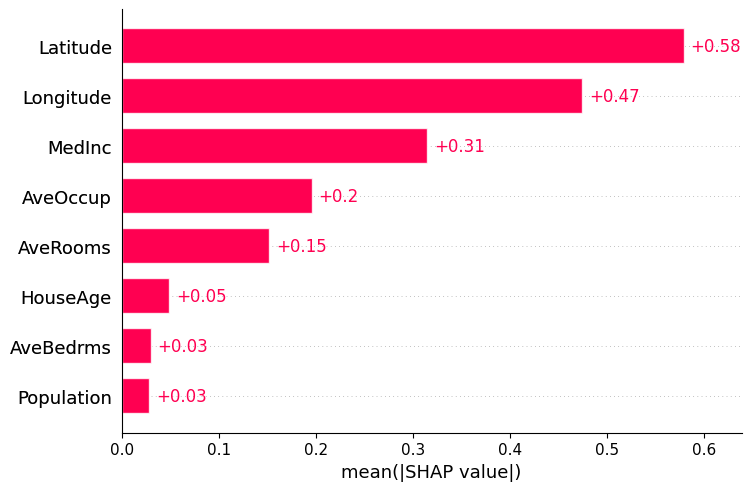

In [32]:
# bar plot to plot feature importance

shap.plots.bar(shap_values)

In [33]:
shap_values.abs.mean(axis=0)

.values =
array([0.31464139, 0.04904455, 0.15196249, 0.02982047, 0.02858452,
       0.19611417, 0.57893087, 0.47412649])

.base_values =
np.float64(1.9987080014120808)

.data =
array([3.83033798e+00, 2.87642926e+01, 5.40405863e+00, 1.09663675e+00,
       1.42157171e+03, 2.96543102e+00, 3.55867103e+01, 1.19519360e+02])

In [34]:
shap_values.abs.mean(axis=0).values

array([0.31464139, 0.04904455, 0.15196249, 0.02982047, 0.02858452,
       0.19611417, 0.57893087, 0.47412649])

In [35]:
dict(zip(feature_names,shap_values.abs.mean(axis=0).values))

{'MedInc': np.float64(0.31464138943341724),
 'HouseAge': np.float64(0.04904455337849559),
 'AveRooms': np.float64(0.15196249450557767),
 'AveBedrms': np.float64(0.029820470676046082),
 'Population': np.float64(0.02858452341483888),
 'AveOccup': np.float64(0.196114166921687),
 'Latitude': np.float64(0.5789308668371527),
 'Longitude': np.float64(0.4741264906259882)}

In [36]:
feature_importances = {feature:shap_val.item() for feature, shap_val in
                    zip(feature_names,shap_values.abs.mean(axis=0).values)}

In [37]:
feature_importances

{'MedInc': 0.31464138943341724,
 'HouseAge': 0.04904455337849559,
 'AveRooms': 0.15196249450557767,
 'AveBedrms': 0.029820470676046082,
 'Population': 0.02858452341483888,
 'AveOccup': 0.196114166921687,
 'Latitude': 0.5789308668371527,
 'Longitude': 0.4741264906259882}

In [38]:
sorted(feature_importances, key=feature_importances.get, reverse=True)

['Latitude',
 'Longitude',
 'MedInc',
 'AveOccup',
 'AveRooms',
 'HouseAge',
 'AveBedrms',
 'Population']

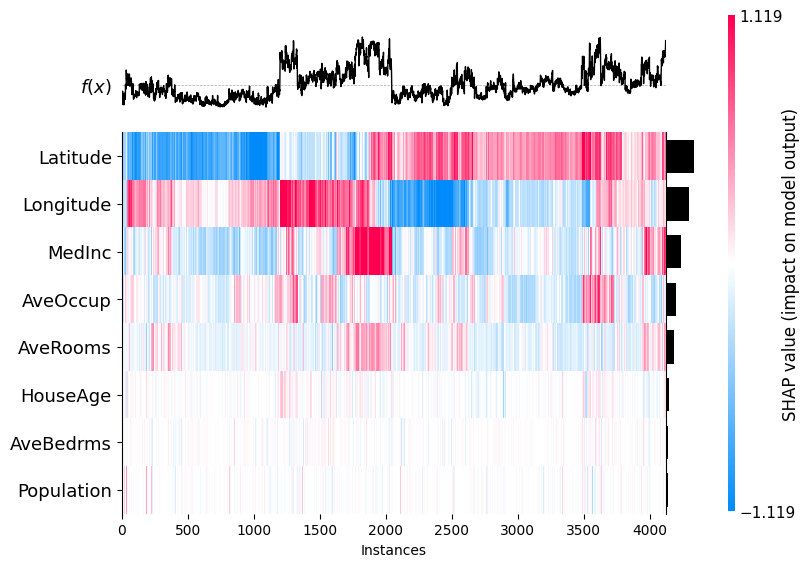

<Axes: xlabel='Instances'>

In [39]:
# heatmap plot

shap.plots.heatmap(shap_values)

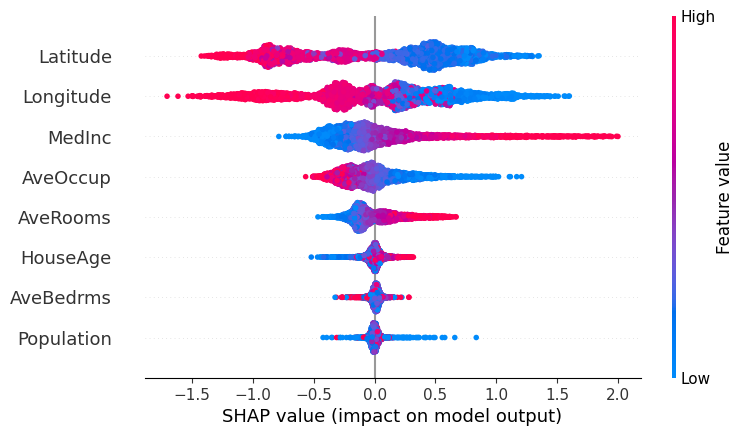

In [40]:
# summary plot

shap.plots.beeswarm(shap_values)

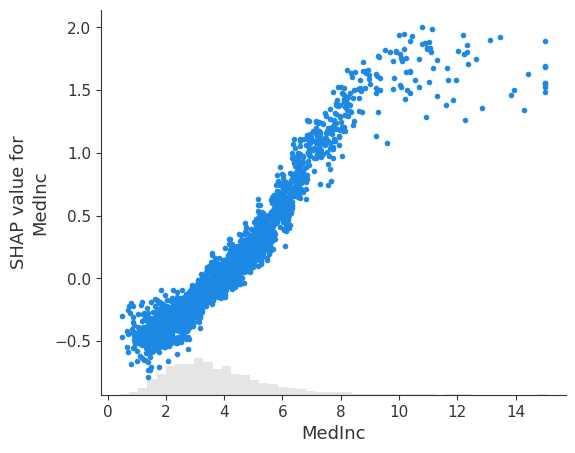

In [41]:
# scatter plot (Dependence Plot)
shap.plots.scatter(shap_values[:, "MedInc"])

In [42]:
shap_values[:, "Latitude"]

.values =
array([-0.72283787, -0.73216523,  0.33648019, ...,  0.03134359,
       -0.9760452 ,  0.1680565 ])

.base_values =
array([1.998708, 1.998708, 1.998708, ..., 1.998708, 1.998708, 1.998708])

.data =
array([36.06, 35.14, 37.8 , ..., 37.31, 36.77, 34.22])

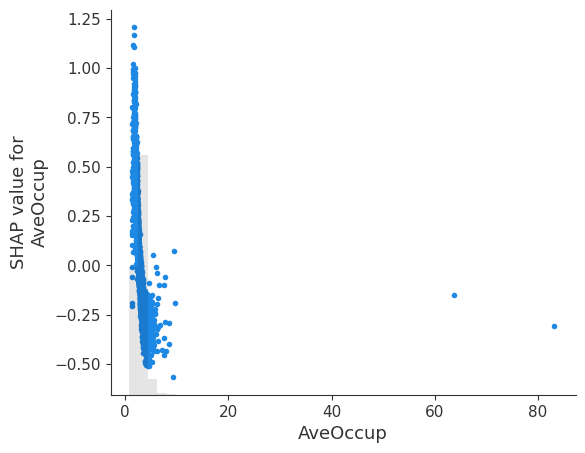

In [43]:
shap.plots.scatter(shap_values[:, "AveOccup"])

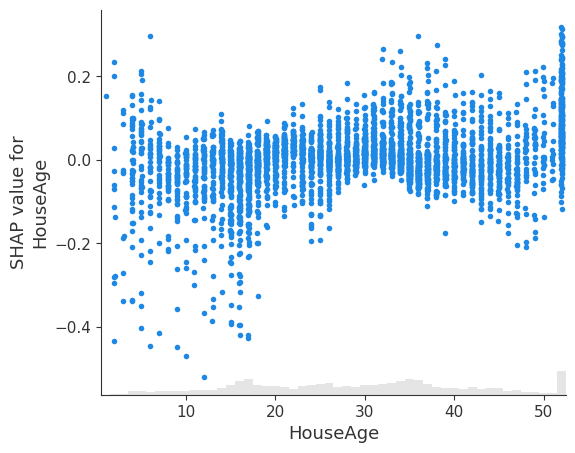

In [44]:
shap.plots.scatter(shap_values[:, "HouseAge"])

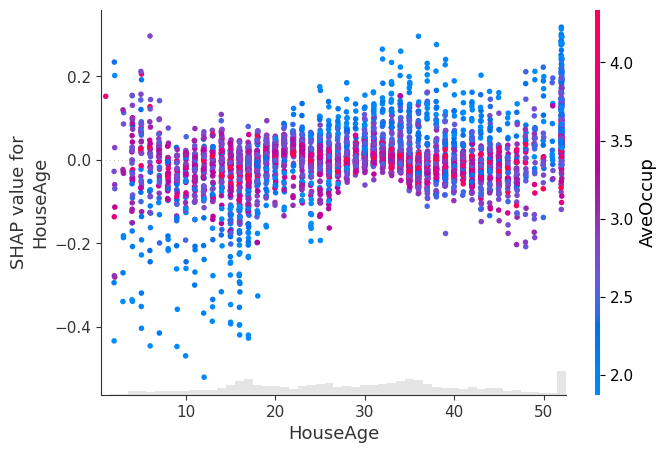

In [45]:
# scatter plot with interaction

shap.plots.scatter(shap_values[:, "HouseAge"], color=shap_values)

# LOCAL PLOTS

In [46]:
test_case = X_test.sample(1)

test_case

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude
8944,2.9167,43.0,4.64,1.216,393.0,1.572,34.01,-118.47


In [47]:
explained_row = explainer(test_case)

explained_row

.values =
array([[-0.22263491,  0.05263846, -0.11524203,  0.11906922, -0.0695316 ,
         0.68385   ,  0.88159031,  0.67531215]])

.base_values =
array([1.998708])

.data =
array([[   2.9167,   43.    ,    4.64  ,    1.216 ,  393.    ,    1.572 ,
          34.01  , -118.47  ]])

In [48]:
explained_row[0,:].shape

(8,)

In [49]:
explained_row.shape

(1, 8)

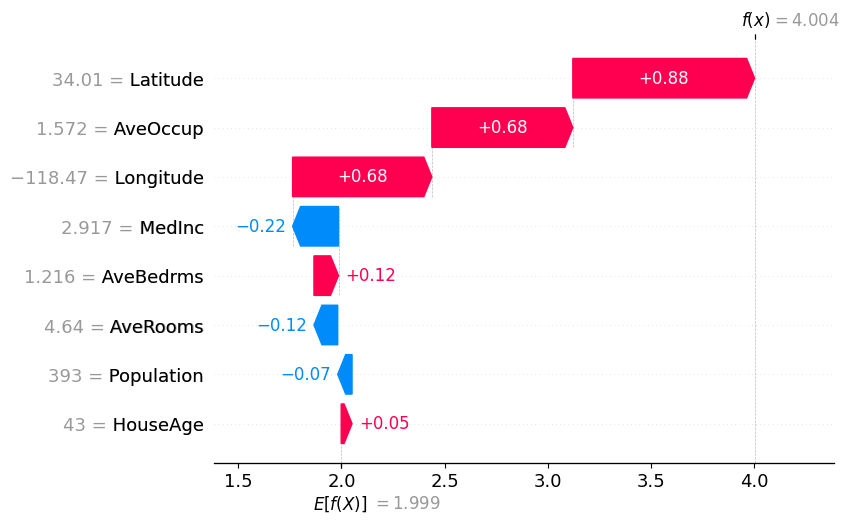

In [50]:
# waterfall plot

shap.plots.waterfall(explained_row[0])

In [51]:
# force plot

shap.plots.initjs()

shap.plots.force(explained_row[0])

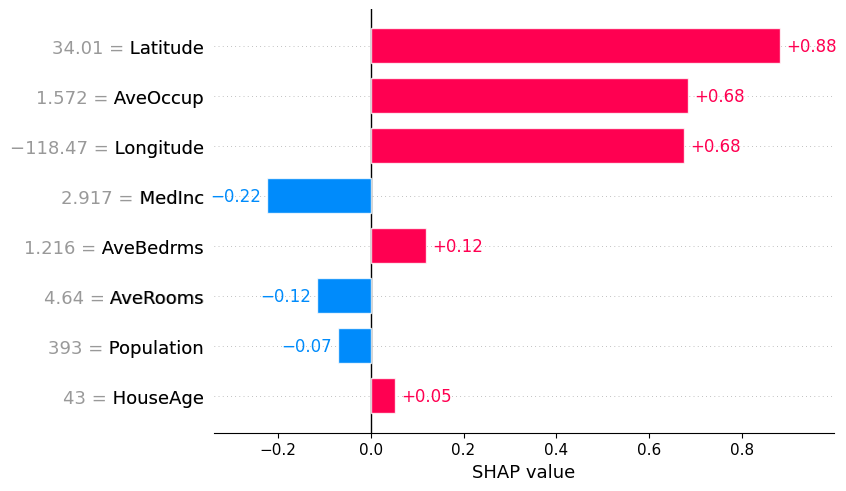

In [52]:
# bar plot for local explaination

shap.plots.bar(explained_row[0])

# LIME

In [53]:
# test case

test_case

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude
8944,2.9167,43.0,4.64,1.216,393.0,1.572,34.01,-118.47


In [54]:
# convert test case to a 1D array

test_case_lime = test_case.values.flatten()

In [55]:
!pip install lime

In [56]:
from lime.lime_tabular import LimeTabularExplainer

In [57]:
X_train.values.shape

(16512, 8)

In [58]:
# feature names

feature_names = X_train.columns.tolist()

In [59]:
# make an lime explainer

lime_explainer = LimeTabularExplainer(
    training_data=X_train.values,
    mode="regression",
    feature_names=feature_names
)

In [60]:
# get the lime explanations

lime_explanation = lime_explainer.explain_instance(
    data_row=test_case_lime,
    predict_fn=xgb_model.predict
)

In [61]:
# lime explanations --> list of values

lime_explanation.as_list()

[('33.93 < Latitude <= 34.26', 0.5709901675430773),
 ('AveOccup <= 2.43', 0.4640121903450338),
 ('2.57 < MedInc <= 3.55', -0.3805883269357729),
 ('-118.51 < Longitude <= -118.01', -0.1860861921446323),
 ('4.45 < AveRooms <= 5.24', -0.15542384017953725),
 ('AveBedrms > 1.10', -0.056107664528972416),
 ('Population <= 789.00', -0.009239670860455025),
 ('HouseAge > 37.00', -0.006085953250486254)]

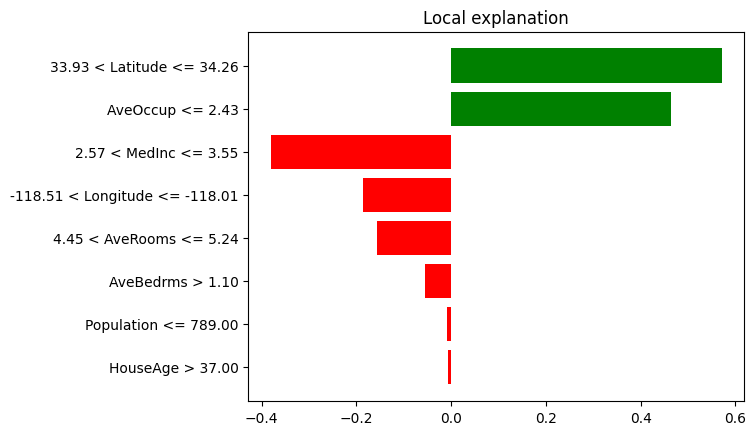

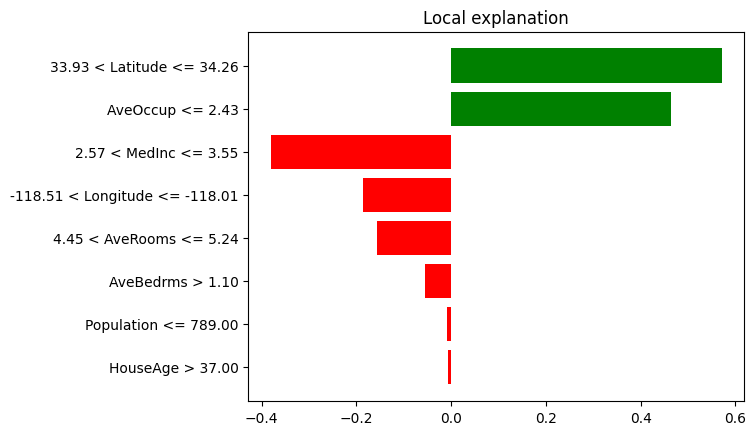

In [62]:
# lime explanations --> pyplot figure

lime_explanation.as_pyplot_figure()

In [63]:
# lime explanations --> as html

from IPython.core.display import HTML

In [64]:
xgb_model.predict(test_case)

array([3.9377103], dtype=float32)

In [65]:
# display explanation

display(HTML(lime_explanation.as_html()))
